## loom to h5

In [ ]:
import loompy
import h5py
import numpy as np

def convert_dtype_for_h5(data):
    """Recursively process all data types to HDF5 compatible format"""
    # Handle None values
    if data is None:
        return np.array([b''], dtype=h5py.string_dtype())
    
    # Convert to numpy array
    arr = np.array(data)
    
    # Handle string types
    if arr.dtype == object:
        try:
            # Try converting string/bytes
            if all(isinstance(x, (str, bytes)) for x in arr):
                return np.array(
                    [x.encode('utf-8') if isinstance(x, str) else x for x in arr],
                    dtype=h5py.string_dtype()
                )
            # Handle mixed numeric and string types
            elif any(isinstance(x, (int, float)) for x in arr):
                return np.array([str(x) for x in arr], dtype=h5py.string_dtype())
            # Handle nested structures (e.g. lists)
            elif any(isinstance(x, (list, tuple)) for x in arr):
                return np.array([str(x) for x in arr], dtype=h5py.string_dtype())
            # Handle mixed None values
            elif any(x is None for x in arr):
                return np.array([str(x) if x is not None else '' for x in arr],
                              dtype=h5py.string_dtype())
        except Exception as e:
            raise ValueError(f"Failed to convert object dtype: {str(e)}")
    
    # Handle numeric types
    if np.issubdtype(arr.dtype, np.integer):
        return arr.astype(np.int32)
    elif np.issubdtype(arr.dtype, np.floating):
        return arr.astype(np.float32)
    
    return arr

# Read loom file
with loompy.connect("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.loom", validate=False) as ds:
    matrix = ds[:, :]  # Expression matrix
    row_attrs = {k: ds.ra[k][:] for k in ds.ra.keys()}  # Automatically converted to numpy arrays
    col_attrs = {k: ds.ca[k][:] for k in ds.ca.keys()}

# Save as HDF5
with h5py.File("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.h5", "w") as f:
    # 1. Save main matrix
    f.create_dataset("expression_matrix", 
                    data=matrix,
                    chunks=True,
                    compression="gzip")
    
    # 2. Process row attributes (genes)
    grp_rows = f.create_group("row_attrs")
    for key, value in row_attrs.items():
        try:
            processed = convert_dtype_for_h5(value)
            grp_rows.create_dataset(key, 
                                   data=processed,
                                   dtype=processed.dtype,
                                   compression="gzip")
        except Exception as e:
            print(f"! Row attribute [{key}] conversion failed: {str(e)}")
            print(f"Sample data: {value[:3]}")
    
    # 3. Process column attributes (cells)
    grp_cols = f.create_group("col_attrs")
    for key, value in col_attrs.items():
        try:
            processed = convert_dtype_for_h5(value)
            grp_cols.create_dataset(key, 
                                   data=processed,
                                   dtype=processed.dtype,
                                   compression="gzip")
        except Exception as e:
            print(f"! Column attribute [{key}] conversion failed: {str(e)}")
            print(f"Sample data: {value[:3]}")

# Verify file structure
print("\nOutput file verification:")
with h5py.File("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.h5", "r") as f:
    print(f"Main matrix: {f['expression_matrix'].shape}")
    
    print("\nRow attributes:")
    for k in f["row_attrs"]:
        ds = f["row_attrs"][k]
        print(f"{k:20} {str(ds.dtype):15} {ds.shape}")
        
    print("\nColumn attributes:")
    for k in f["col_attrs"]:
        ds = f["col_attrs"][k]
        print(f"{k:20} {str(ds.dtype):15} {ds.shape}")

! 列属性 [reducedDims_HARMONY_colnames] 转换失败: Object dtype dtype('O') has no native HDF5 equivalent
样本数据: [['harmony_1']
 ['harmony_2']
 ['harmony_3']]
! 列属性 [reducedDims_PCA_colnames] 转换失败: Object dtype dtype('O') has no native HDF5 equivalent
样本数据: [['PC_1']
 ['PC_2']
 ['PC_3']]
! 列属性 [reducedDims_TSNE_colnames] 转换失败: Object dtype dtype('O') has no native HDF5 equivalent
样本数据: [['tSNE_1']
 ['tSNE_2']
 ['']]
! 列属性 [reducedDims_UMAP_colnames] 转换失败: Object dtype dtype('O') has no native HDF5 equivalent
样本数据: [['umap_1']
 ['umap_2']
 ['']]

输出文件验证:
主矩阵: (37851, 4832)

行属性:
var_names            object          (37851,)

列属性:
RNA_snn_res.0.05     object          (4832,)
RNA_snn_res.0.9      object          (4832,)
celltype             object          (4832,)
group                object          (4832,)
ident                object          (4832,)
nCount_RNA           float32         (4832,)
nFeature_RNA         int32           (4832,)
obs_names            object          (4832,)
orig.ident   

查看h5文件是什么格式

In [ ]:
import h5py

with h5py.File("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.h5", "r") as f:
    print("File structure:")
    print(list(f.keys()))  # Show top-level groups/datasets
    
    # For 10x format, check if "matrix" group exists
    if "matrix" in f:
        print("\nmatrix group contents:")
        print(list(f["matrix"].keys()))  # Show substructure
    
    # For AnnData, check for "obs" and "var"
    if "obs" in f:
        print("\nAnnData format obs group:")
        print(list(f["obs"].keys()))

文件结构:
['col_attrs', 'expression_matrix', 'row_attrs']


若是AnnData格式：

In [ ]:
import h5py

with h5py.File("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.h5", "r") as f:
    # Check all fields in row_attrs (gene metadata)
    print("Fields in row_attrs:")
    if "row_attrs" in f:
        for key in f["row_attrs"].keys():
            data = f["row_attrs"][key][()]
            print(f"  - {key}: dtype={data.dtype}, shape={data.shape}")

    # Check all fields in col_attrs (cell metadata)
    print("\nFields in col_attrs:")
    if "col_attrs" in f:
        for key in f["col_attrs"].keys():
            data = f["col_attrs"][key][()]
            print(f"  - {key}: dtype={data.dtype}, shape={data.shape}")

行属性 (row_attrs) 中的字段:
  - var_names: 数据类型=object, 形状=(37851,)

列属性 (col_attrs) 中的字段:
  - RNA_snn_res.0.05: 数据类型=object, 形状=(4832,)
  - RNA_snn_res.0.9: 数据类型=object, 形状=(4832,)
  - celltype: 数据类型=object, 形状=(4832,)
  - group: 数据类型=object, 形状=(4832,)
  - ident: 数据类型=object, 形状=(4832,)
  - nCount_RNA: 数据类型=float32, 形状=(4832,)
  - nFeature_RNA: 数据类型=int32, 形状=(4832,)
  - obs_names: 数据类型=object, 形状=(4832,)
  - orig.ident: 数据类型=object, 形状=(4832,)
  - percent.mt: 数据类型=float32, 形状=(4832,)
  - reducedDims_HARMONY: 数据类型=float32, 形状=(4832, 50)
  - reducedDims_PCA: 数据类型=float32, 形状=(4832, 50)
  - reducedDims_TSNE: 数据类型=float32, 形状=(4832, 2)
  - reducedDims_UMAP: 数据类型=float32, 形状=(4832, 2)
  - seurat_clusters: 数据类型=object, 形状=(4832,)
  - subcelltype: 数据类型=object, 形状=(4832,)


### 创建AnnData对象

In [ ]:
import h5py
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix

with h5py.File("/h/dongmadanni/menial_work/cell2drug/MyoFBcell_final22.h5", "r") as f:
    # ----------------------------
    # 1. Read core data
    # ----------------------------
    # Expression matrix (shape: genes × cells)
    matrix = f["expression_matrix"][()]
    matrix = csr_matrix(matrix.T)  # Transpose to cells × genes and convert to sparse matrix

    # ----------------------------
    # 2. Process row attributes (gene metadata)
    # ----------------------------
    # Gene names (var_names)
    gene_names = f["row_attrs/var_names"][()].astype(str)
    var = pd.DataFrame(index=gene_names)  # Gene index

    # ----------------------------
    # 3. Process column attributes (cell metadata)
    # ----------------------------
    # Cell names (obs_names)
    cell_names = f["col_attrs/obs_names"][()].astype(str)
    
    # Build cell metadata table (obs)
    obs_data = {
        # Basic metadata
        "orig.ident": f["col_attrs/orig.ident"][()].astype(str),
        "seurat_clusters": f["col_attrs/seurat_clusters"][()].astype(str),
        "celltype": f["col_attrs/celltype"][()].astype(str),
        "subcelltype": f["col_attrs/subcelltype"][()].astype(str),
        "group": f["col_attrs/group"][()].astype(str),
        "ident": f["col_attrs/ident"][()].astype(str),
        # Quality control metrics
        "nCount_RNA": f["col_attrs/nCount_RNA"][()].astype(np.float32),
        "nFeature_RNA": f["col_attrs/nFeature_RNA"][()].astype(np.int32),
        "percent.mt": f["col_attrs/percent.mt"][()].astype(np.float32),
        # Clustering resolution parameters (optional)
        # "RNA_snn_res.0.1": f["col_attrs/RNA_snn_res.0.1"][()].astype(str),
        "RNA_snn_res.0.05": f["col_attrs/RNA_snn_res.0.05"][()].astype(str),
        "RNA_snn_res.0.9": f["col_attrs/RNA_snn_res.0.9"][()].astype(str)
    }
    obs = pd.DataFrame(obs_data, index=cell_names)

    # ----------------------------
    # 4. Read dimensionality reduction results (stored in obsm)
    # ----------------------------
    obsm = {
        "X_pca": f["col_attrs/reducedDims_PCA"][()],
        "X_harmony": f["col_attrs/reducedDims_HARMONY"][()],
        "X_tsne": f["col_attrs/reducedDims_TSNE"][()],
        "X_umap": f["col_attrs/reducedDims_UMAP"][()]
    }

# Create AnnData object
adata = sc.AnnData(
    X=matrix,
    obs=obs,
    var=var,
    obsm=obsm
)

In [ ]:
# Check dimensions
print(f"Dataset shape: {adata.shape} (cells × genes)")
print(f"Dimensionality reduction coordinates - UMAP: {adata.obsm['X_umap'].shape}")

# View metadata for first 5 cells
print("\nCell metadata sample:")
print(adata.obs.head())

# View gene information
print("\nGene information sample:")
print(adata.var.head())

数据集形状: (4832, 37851) (cells × genes)
降维坐标形状 - UMAP: (4832, 2)

细胞元数据示例:
            orig.ident seurat_clusters celltype subcelltype group   ident  \
CELL21_N2_1         H1               0    MyoFB      MyoFB1     H  MyoFB1   
CELL34_N2_1         H1               1    MyoFB      MyoFB2     H  MyoFB2   
CELL63_N2_1         H1               0    MyoFB      MyoFB1     H  MyoFB1   
CELL78_N2_1         H1               0    MyoFB      MyoFB1     H  MyoFB1   
CELL89_N2_1         H1               1    MyoFB      MyoFB2     H  MyoFB2   

             nCount_RNA  nFeature_RNA  percent.mt RNA_snn_res.0.05  \
CELL21_N2_1      2140.0          1353    8.598131                0   
CELL34_N2_1     16391.0          5430    0.823623                1   
CELL63_N2_1      8788.0          3130   14.644970                0   
CELL78_N2_1     10791.0          4413    9.887870                0   
CELL89_N2_1     11801.0          4590    0.915177                1   

            RNA_snn_res.0.9  
CELL21_N2_1   

## 绘图

In [ ]:
import scanpy as sc
import drug2cell as d2c
import blitzgsea as blitz

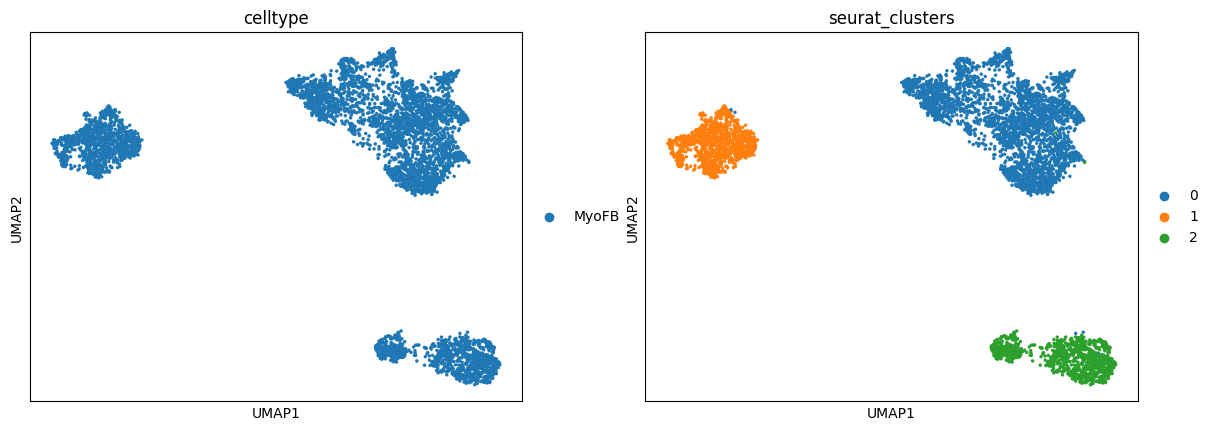

In [ ]:
sc.pl.umap(adata, color=["celltype", "seurat_clusters"])

In [ ]:
d2c.score(adata, use_raw=True)

In [ ]:
print(adata.uns['drug2cell'].obs.columns)
# ['celltype', 'seurat_clusters', ...]

Index(['orig.ident', 'seurat_clusters', 'celltype', 'subcelltype', 'group',
       'ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.05',
       'RNA_snn_res.0.9'],
      dtype='object')


In [ ]:
print(adata.obs.columns.tolist())

['orig.ident', 'seurat_clusters', 'celltype', 'subcelltype', 'group', 'ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.05', 'RNA_snn_res.0.9']


In [ ]:
print(adata.obs['subcelltype'].unique().tolist())

['MyoFB1', 'MyoFB2', 'MyoFB3']


In [ ]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="subcelltype")

In [ ]:
# Check if genes in drug2cell match original adata
print("Number of genes in adata.uns['drug2cell']:", adata.uns['drug2cell'].n_vars)
print("Number of genes in original adata:", adata.n_vars)

# Check for shared genes
shared_genes = set(adata.var_names) & set(adata.uns['drug2cell'].var_names)
print("Number of shared genes:", len(shared_genes))

adata.uns['drug2cell'] 的基因数: 2447
原始 adata 的基因数: 37851
共有基因数: 0


In [ ]:
groupby = 'subcelltype'
n_genes = 5  
top_genes = []
groups = adata.uns['drug2cell'].obs[groupby].unique().tolist()
for group in groups:
    # topN 
    genes = sc.get.rank_genes_groups_df(adata.uns['drug2cell'], group=group)['names'].head(n_genes).tolist()
    top_genes.extend(genes)

top_genes = list(dict.fromkeys(top_genes))
print(top_genes)

['CHEMBL1433|DOXYCYCLINE ANHYDROUS', 'CHEMBL256997|ATALUREN', 'CHEMBL1703|METFORMIN HYDROCHLORIDE', 'CHEMBL1743043|MOXETUMOMAB PASUDOTOX', 'CHEMBL1201550|DENILEUKIN DIFTITOX', 'CHEMBL1382|TOLTERODINE', 'CHEMBL3305985|ALCURONIUM', 'CHEMBL376897|METHSCOPOLAMINE', 'CHEMBL1346|DARIFENACIN', 'CHEMBL1491|AMLODIPINE', 'CHEMBL4297852|CENEGERMIN', 'CHEMBL3889654|LAROTRECTINIB', 'CHEMBL3989939|LAROTRECTINIB SULFATE', 'CHEMBL1569|AMANTADINE HYDROCHLORIDE', 'CHEMBL284348|DALFAMPRIDINE']


In [ ]:
drug_adata = adata.uns['drug2cell']
print(drug_adata)
#  Extract target genes for each drug (assuming column name is 'target_genes')
drug_targets = drug_adata.var['all_genes'].tolist()
print(drug_targets)
drug2cell_genes = adata.uns['drug2cell'].var_names.tolist()
print(drug2cell_genes)
adata_genes = adata.var_names.tolist()
print(adata_genes)

AnnData object with n_obs × n_vars = 4832 × 2447
    obs: 'orig.ident', 'seurat_clusters', 'celltype', 'subcelltype', 'group', 'ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.05', 'RNA_snn_res.0.9'
    var: 'genes', 'all_genes'
    uns: 'rank_genes_groups'
    obsm: 'X_pca', 'X_harmony', 'X_tsne', 'X_umap'
['SLC6A2', 'SSTR1,SSTR5,SSTR4,SSTR3,SSTR2', 'COL1A2,COL1A1,COL18A1,COL5A3,COL11A2,COL27A1,COL11A1,COL4A5,COL4A6,COL2A1,COL28A1,COL15A1,COL6A6,COL6A5,COL5A2,COL4A4,COL6A1,COL6A2,COL4A3,COL3A1,COL4A2,COL4A1,COL5A1,COL24A1,COL6A3', 'SMN2,SMN1', 'RPL37,RPS21,RPSA,RPS7,RPLP0,RPL23A,RPL21,RPS3,RPS14,RPS23,RPS6,RPS20,RPS16,RPL19,RPL38,RPL11,RPS28,RPS18,RPL5,RPL26,RPL32,RPL28,RPL8,RPL9P7,RPL39,RPS4Y1,RPL37A,RPL9,RPS10,RPL18,RPL36A,RPS29,RPL27,RPS9,RPL34,RPS3A,RPS15,RPL10A,RPS5,RPS27,RPL9P9,RPL4,RPL13A,RPL15,RPL29,RPL17,RPLP1,RPL3,RPS15A,FAU,RPL31,RPS11,RPL24,RPL10,RPL13,RPL6,RPL23,RPS26,RPS17,RPL35A,RPS2,RPS12,RPL14,RPS4X,RPS24,RPL7A,RPS13,RPL9P8,RPS27A,RPS8,RPL12,RPL30,R

In [ ]:

new_var_names = [
    f"{drug} [{', '.join(targets.split(',')[:1])}]"   # 只显示前1个基因
    for drug, targets in zip(drug_adata.var_names, drug_targets)
]

drug_adata.var_names = new_var_names
print(drug_adata.var_names)

Index(['CHEMBL1615779|IOBENGUANE I 131 [SLC6A2]',
       'CHEMBL3989924|LUTETIUM DOTATATE LU-177 [SSTR1]',
       'CHEMBL2108709|COLLAGENASE CLOSTRIDIUM HISTOLYTICUM [COL1A2]',
       'CHEMBL4297240|ONASEMNOGENE ABEPARVOVEC [SMN2]',
       'CHEMBL256997|ATALUREN [RPL37]', 'CHEMBL1201556|BECAPLERMIN [PDGFRA]',
       'CHEMBL2010601|IVACAFTOR [CFTR]', 'CHEMBL1229908|ETHAMIVAN [BLM]',
       'CHEMBL1200689|NITRIC OXIDE [GUCY1B2]',
       'CHEMBL1622|FOLIC ACID [HSD17B10]',
       ...
       'CHEMBL690|PRAVASTATIN SODIUM [HMGCR]',
       'CHEMBL1201118|CEFMETAZOLE SODIUM [POLH]',
       'CHEMBL1200759|ANAGRELIDE HYDROCHLORIDE [PDE3A]',
       'CHEMBL3989410|INDOMETHACIN SODIUM [PTGS2]',
       'CHEMBL88|CYCLOPHOSPHAMIDE [EHMT2]',
       'CHEMBL1201142|RASAGILINE MESYLATE [MAOB]',
       'CHEMBL1484251|CHLORHEXIDINE HYDROCHLORIDE [KMT2A]',
       'CHEMBL93|ZILEUTON [LTA4H]',
       'CHEMBL1200463|OXAPROZIN POTASSIUM [PTGS2]',
       'CHEMBL1375743|ZIPRASIDONE HYDROCHLORIDE [DRD2]'],
      d

In [ ]:
sc.tl.rank_genes_groups(drug_adata, method="wilcoxon", groupby="subcelltype")


In [ ]:
groupby = 'subcelltype'
n_genes = 5 

top_genes = []
groups = drug_adata.obs[groupby].unique().tolist()
for group in groups:
    genes = sc.get.rank_genes_groups_df(drug_adata, group=group)['names'].head(n_genes).tolist()
    top_genes.extend(genes)

top_genes = list(dict.fromkeys(top_genes))
print(top_genes)

['CHEMBL1433|DOXYCYCLINE ANHYDROUS [EHMT2]', 'CHEMBL256997|ATALUREN [RPL37]', 'CHEMBL1703|METFORMIN HYDROCHLORIDE [MT-ND4]', 'CHEMBL1743043|MOXETUMOMAB PASUDOTOX [EEF2]', 'CHEMBL1201550|DENILEUKIN DIFTITOX [IL2RG]', 'CHEMBL1382|TOLTERODINE [KCNH2]', 'CHEMBL3305985|ALCURONIUM [CHRM2]', 'CHEMBL376897|METHSCOPOLAMINE [CHRM2]', 'CHEMBL1346|DARIFENACIN [ADRB2]', 'CHEMBL1491|AMLODIPINE [CACNA1C]', 'CHEMBL4297852|CENEGERMIN [NTRK1]', 'CHEMBL3889654|LAROTRECTINIB [NTRK1]', 'CHEMBL3989939|LAROTRECTINIB SULFATE [NTRK1]', 'CHEMBL1569|AMANTADINE HYDROCHLORIDE [GRIN2B]', 'CHEMBL284348|DALFAMPRIDINE [KCNQ1]']


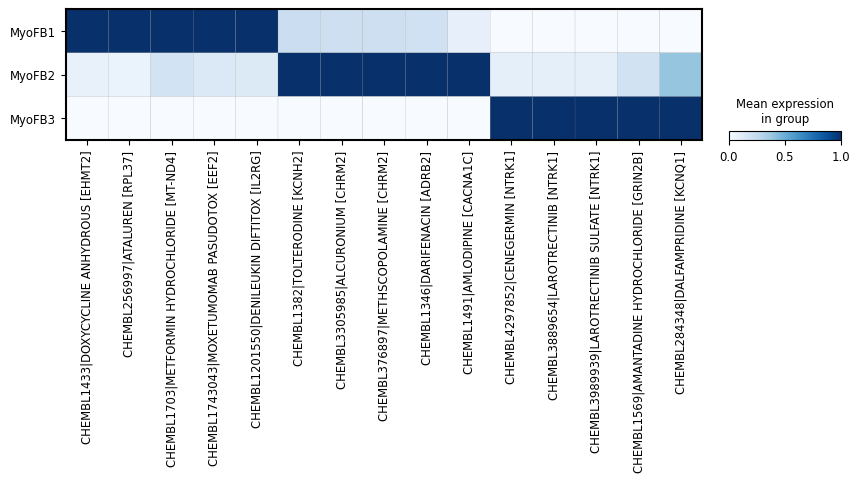

In [ ]:
sc.pl.matrixplot(
    drug_adata,
    var_names=top_genes,
    groupby="subcelltype",
    cmap="Blues",
    # swap_axes=True,
    standard_scale='var',  
    vmin=0,                
    vmax=1.0,              
    figsize=(10, 1.7),
    show=False  
)

plt.savefig(
    "matrixplot.pdf",      
    dpi=300,                
    bbox_inches='tight',    
    facecolor='white',     
    format='pdf'           
)

[<Axes: >, <Axes: >, <Axes: title={'center': 'Mean expression\nin group'}>]


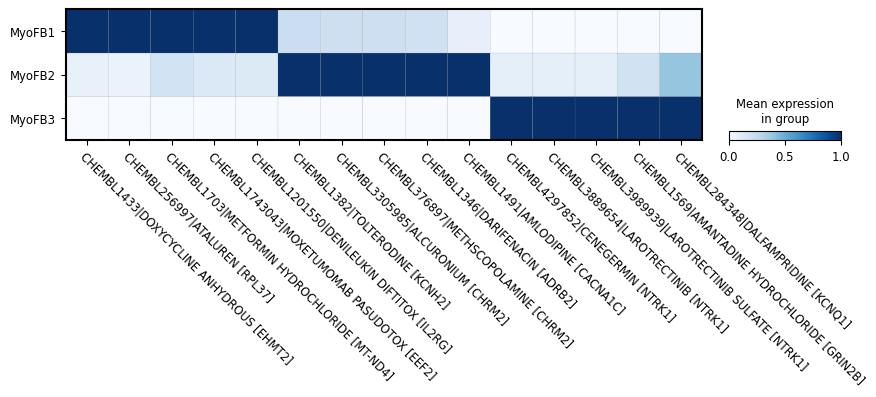

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

sc.pl.matrixplot(
    drug_adata,
    var_names=top_genes,
    groupby="subcelltype",
    cmap="Blues",
    standard_scale='var',
    vmin=0,
    vmax=1.0,
    figsize=(10, 1.7),
    show=False
)

all_axes = plt.gcf().get_axes()
print(all_axes)
main_ax = all_axes[0]  
main_ax.set_xticklabels(main_ax.get_xticklabels(), rotation=-45, ha='left', rotation_mode='anchor')

plt.savefig(
    "matrixplot.pdf",       
    dpi=500,                
    bbox_inches='tight',    
    facecolor='white',      
    format='pdf'            
)
